<a href="https://colab.research.google.com/github/dnth/dnth.github.io/blob/main/static/images/blog/deploy-icevision-hfspace/training_vfnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started with Object Detection using IceVision

In [1]:
from icevision.all import *

INFO     - The mmdet config folder already exists. No need to downloaded it. Path : /home/dnth/.icevision/mmdetection_configs/mmdetection_configs-2.20.1/configs | icevision.models.mmdet.download_configs:download_mmdet_configs:17


In [2]:
# Create the parser
parser = parsers.VOCBBoxParser(annotations_dir="data/labeled", images_dir="data/labeled")

In [3]:
# Parse annotations to create records
train_records, valid_records = parser.parse()
parser.class_map

  0%|          | 0/17 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/17 [00:00<?, ?it/s]

<ClassMap: {'background': 0, 'Microalgae': 1}>

In [4]:
# Transforms
image_size = 640
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=image_size, presize=image_size+128), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(image_size), tfms.A.Normalize()])

In [5]:
# Datasets
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

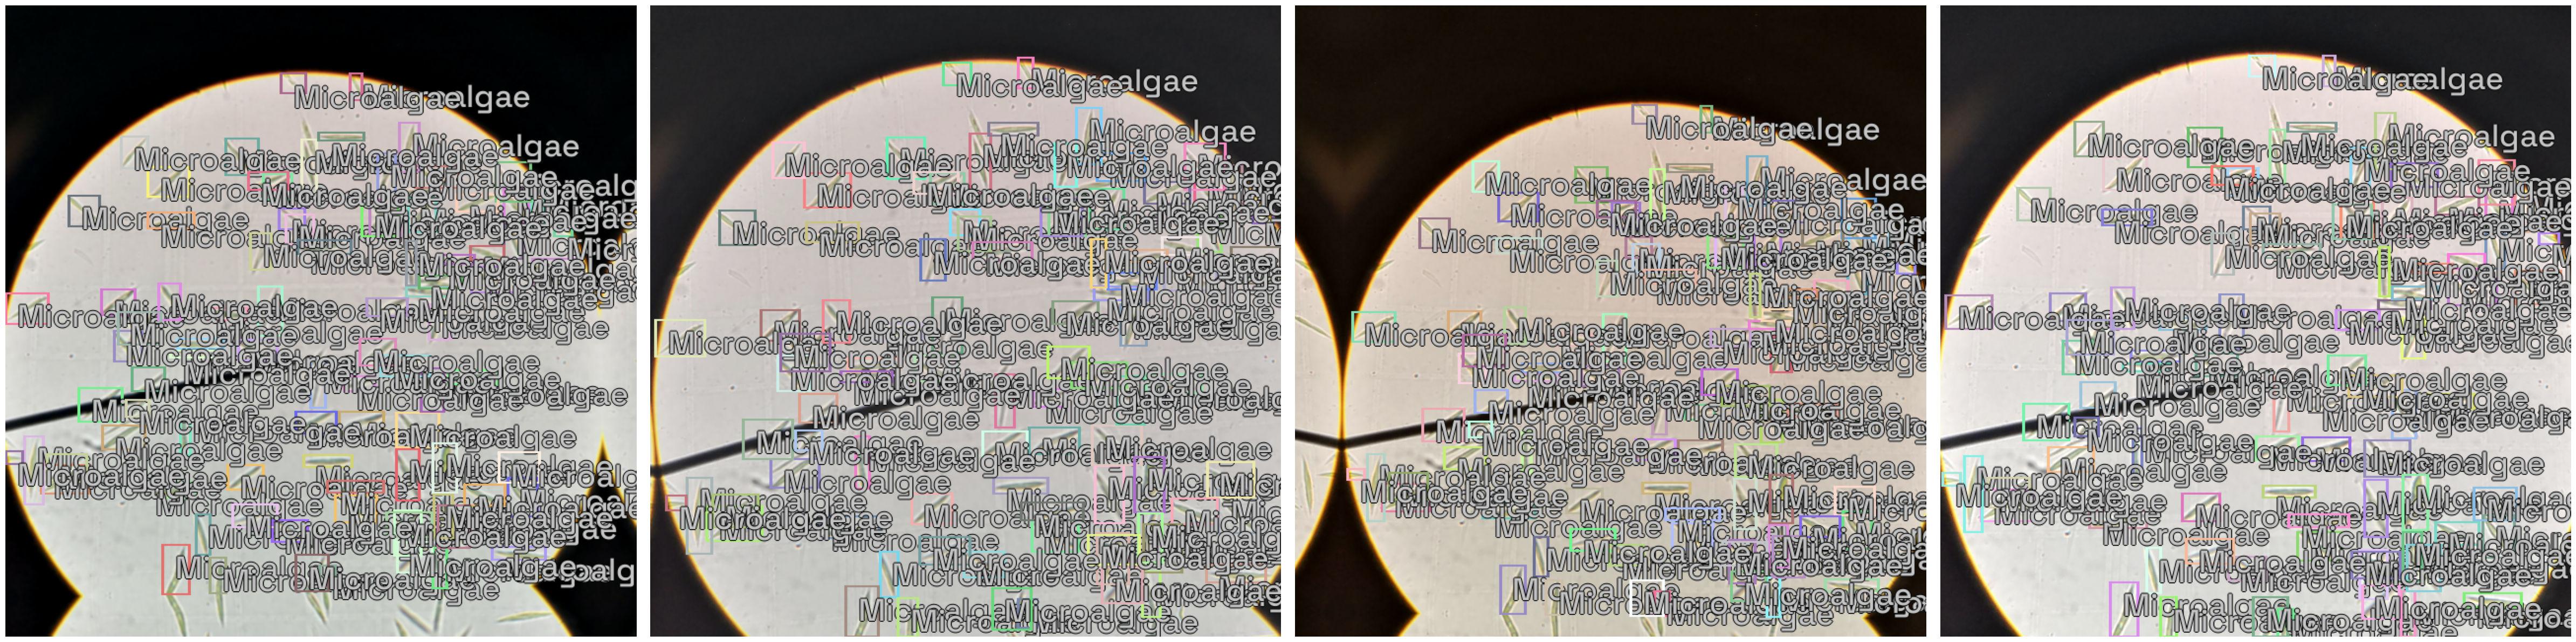

In [6]:
# Show an element of the train_ds with augmentation transformations applied
samples = [train_ds[0] for _ in range(4)]
show_samples(samples, ncols=4)

In [7]:
model_type = models.mmdet.vfnet
backbone = model_type.backbones.resnet50_fpn_mstrain_2x
model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(parser.class_map)) 

/home/dnth/anaconda3/envs/algae-blog/lib/python3.8/site-packages/mmdet/core/anchor/builder.py:16: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  warnings.warn(
2022-04-09 11:51:41,119 - mmcv - INFO - initialize ResNet with init_cfg {'type': 'Pretrained', 'checkpoint': 'torchvision://resnet50'}
2022-04-09 11:51:41,120 - mmcv - INFO - load model from: torchvision://resnet50
2022-04-09 11:51:41,120 - mmcv - INFO - load checkpoint from torchvision path: torchvision://resnet50
2022-04-09 11:51:41,195 - mmcv - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

2022-04-09 11:51:41,216 - mmcv - INFO - initialize FPN with init_cfg {'type': 'Xavier', 'layer': 'Conv2d', 'distribution': 'uniform'}
2022-04-09 11:51:41,235 - mmcv - INFO - initialize VFNetHead with init_cfg {'type': 'Normal', 'layer': 'Conv2d', 'std': 0.01, 'override': {'type': 'Normal', 'name': 'vfnet_cls'

load checkpoint from local path: checkpoints/vfnet/vfnet_r50_fpn_mstrain_2x_coco_20201027-7cc75bd2.pth
The model and loaded state dict do not match exactly

size mismatch for bbox_head.vfnet_cls.weight: copying a param with shape torch.Size([80, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([1, 256, 3, 3]).
size mismatch for bbox_head.vfnet_cls.bias: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([1]).


In [8]:
# Data Loaders
train_dl = model_type.train_dl(train_ds, batch_size=2, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=2, num_workers=4, shuffle=False)

In [9]:
# Metrics
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

In [10]:
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

/home/dnth/anaconda3/envs/algae-blog/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/dnth/anaconda3/envs/algae-blog/lib/python3.8/site-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/home/dnth/anaconda3/envs/algae-blog/lib/python3.8/site-packages/mmdet/core/anchor/anchor_generator.py:360: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  warnings.warn(


SuggestedLRs(valley=0.0010000000474974513)

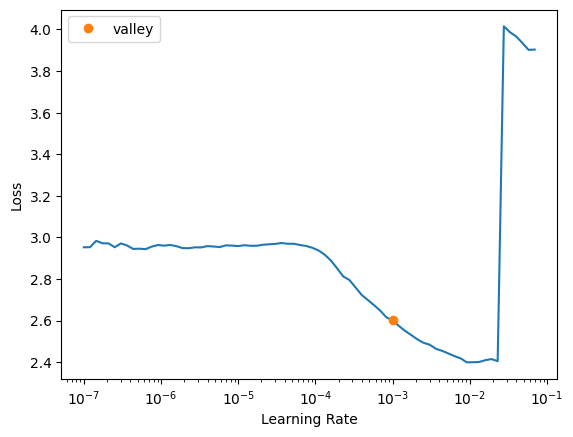

In [11]:
learn.lr_find()

In [ ]:
learn.fine_tune(10, 3e-4, freeze_epochs=1)

In [ ]:
model_type.show_results(model, valid_ds, detection_threshold=.5)

In [ ]:
from icevision.models.checkpoint import *
save_icevision_checkpoint(model,
                        model_name='mmdet.vfnet', 
                        backbone_name='resnet50_fpn_mstrain_2x',
                        img_size=640,
                        classes=parser.class_map.get_classes(),
                        filename='./models/model_checkpoint.pth',
                        meta={'icevision_version': '0.12.0'})